# Sensores Phybox

## Datos adquiridos

Para la realización del ejercicio se recogen datos de:
* Subir escaleras
* Bajar escaleras
* Caminar
* Correr
* Estar quieto en el metro

Conocemos que, poniendo el móvil sobre la mesa:
* El eje x es el que va de izquierda a derecha
* El eje y es el que va de delante a detrás
* El eje z es el que va de arriba a abajo
* Además, el acelerómetro mide la aceleración en m/s^2

In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from scipy.signal import get_window#, rfft, rfftfreq

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [2]:
def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

### 1. Carga de datos

In [3]:
# Solo aceleración en los tres ejes, absoluta no
def carga_df(filename, etiqueta):
    df = pd.read_csv(os.path.join('data', filename)).iloc[:, :4]
    df['etiqueta'] = etiqueta
    df.columns = ['time', 'x', 'y', 'z', 'etiqueta']
    return df

In [13]:
df_bajar1 = carga_df('bajar_escaleras_1.csv', 'bajar_escaleras')
df_bajar2 = carga_df('bajar_escaleras_2.csv', 'bajar_escaleras')
df_subir = carga_df('subir_escaleras.csv', 'subir_escaleras')
df_metro = carga_df('enelmetro.csv', 'metro')

In [14]:
df_bajar1.shape

(5638, 5)

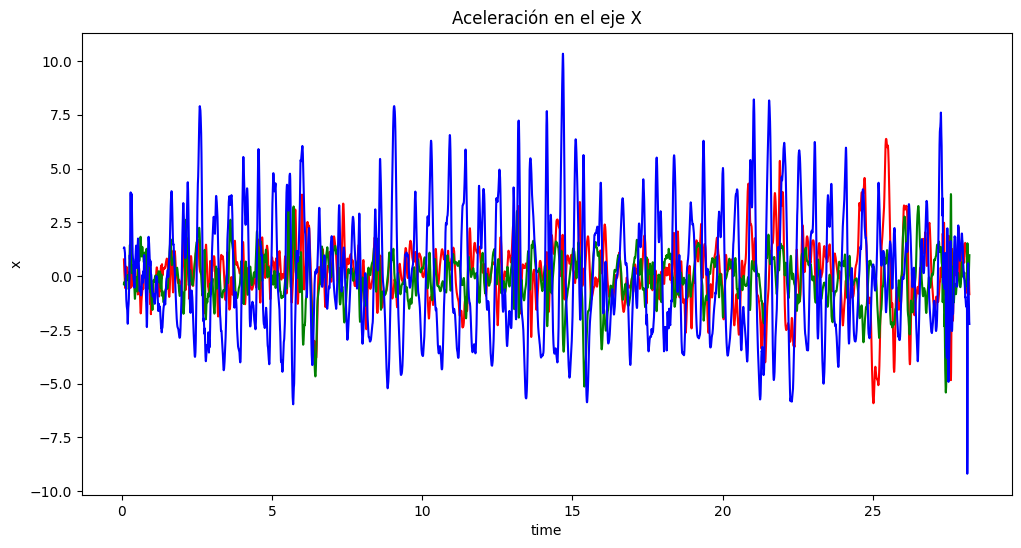

In [15]:
# Visualizar los datos
setup_graph(title='Aceleración en el eje X', x_label='time', y_label='x', fig_size=(12, 6))
plt.plot(df_bajar1['time'], df_bajar1['x'], color='r')
plt.plot(df_bajar1['time'], df_bajar1['y'], color='g')
plt.plot(df_bajar1['time'], df_bajar1['z'], color='b')
plt.show()

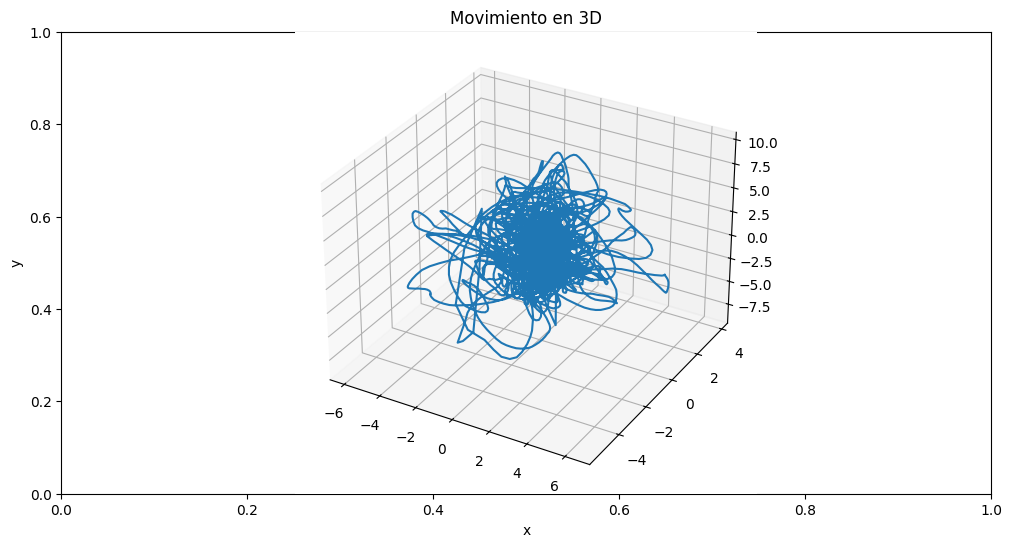

In [16]:
# Recreación del movimiento en 3D
from mpl_toolkits.mplot3d import Axes3D

setup_graph(title='Movimiento en 3D', x_label='x', y_label='y', fig_size=(12, 6))
ax = plt.subplot(111, projection='3d')
ax.plot(df_bajar1['x'], df_bajar1['y'], df_bajar1['z'])
plt.show()

MovieWriter imagemagick unavailable; using Pillow instead.


KeyboardInterrupt: 

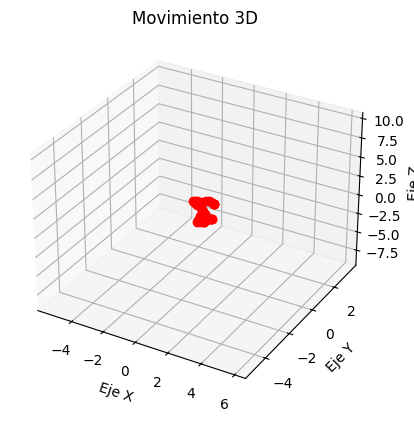

In [17]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# Configuración inicial para la figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Configurar los límites del gráfico según tus datos
ax.set_xlim([df_bajar1['x'].min(), df_bajar1['x'].max()])
ax.set_ylim([df_bajar1['y'].min(), df_bajar1['y'].max()])
ax.set_zlim([df_bajar1['z'].min(), df_bajar1['z'].max()])

# Titulo y etiquetas
ax.set_title('Movimiento 3D')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')

# Función de inicialización: plota el fondo de cada cuadro
def init():
    ax.plot(df_bajar1['x'][0:1], df_bajar1['y'][0:1], df_bajar1['z'][0:1], 'ro')
    return fig,

# Función de animación: se llama secuencialmente
def animate(i):
    ax.plot(df_bajar1['x'][i:i+1], df_bajar1['y'][i:i+1], df_bajar1['z'][i:i+1], 'ro')
    return fig,

# Llamar al animador, blit=True significa que solo se redibuja lo que ha cambiado
ani = animation.FuncAnimation(fig, animate, init_func=init,
                              frames=len(df_bajar1), interval=20000, blit=True)

# Guardar la animación
ani.save('movimiento_3d.gif', writer='imagemagick', fps=60)

## Metodología

### 2. Obtener características con una ventana móvil que se va solapando: en el dominio del tiempo

In [18]:
# Cada ventana tendrá 1000 puntos, y el dataframe para clasificar contendrá una fila por ventana y una columna por característica extraída, además de la etiqueta

#### - Dominio del tiempo

In [22]:
# Dominio del tiempo: max, min, std, kurtosis...
def freq_features(raw_df, window_size=1000, step_size=200):
    data = []
    for i in range(0, len(raw_df)-window_size, step_size):
        window = raw_df[i:i+window_size]
        features = {}
        for axis in ['x', 'y', 'z']:
            features[f'{axis}_min'] = window[axis].min()
            features[f'{axis}_max'] = window[axis].max()
            features[f'{axis}_median'] = window[axis].median()
            features[f'{axis}_mean'] = window[axis].mean()
            features[f'{axis}_std'] = window[axis].std()
            features[f'{axis}_skewness'] = window[axis].skew()
            features[f'{axis}_kurtosis'] = window[axis].kurtosis()
            features[f'{axis}_iqr'] = window[axis].quantile(0.75) - window[axis].quantile(0.25)
            features[f'{axis}_entropy'] = -np.sum(window[axis] * np.log(window[axis]))
            #features[f'{axis}_mad'] = window[axis].mad()
            features[f'{axis}_rms'] = np.sqrt(np.mean(window[axis]**2))          
        features['etiqueta'] = window['etiqueta'].iloc[0]
        data.append(features)
    
    # Generar nombres de columnas basados en las claves del primer elemento de 'data'
    columns = list(data[0].keys())
    return pd.DataFrame(data, columns=columns)

In [23]:
(5600-1000)/200 # (n_puntos-ventana_size)/step_size = n_ventanas --> hacer un esquemita

23.0

In [24]:
df_bajar1_features = freq_features(df_bajar1)
df_bajar2_features = freq_features(df_bajar2)
df_subir_features = freq_features(df_subir)
df_metro_features = freq_features(df_metro)

# Concatenar los dataframes
df_caracts_tiempo_1 = pd.concat([df_bajar1_features, df_bajar2_features, df_subir_features, df_metro_features], ignore_index=True)

c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Jon\anaconda3\envs\reto11\lib\site-packages\pandas\core\arraylike.

### 3. Clasificador 1: RF, xgboost, SVM, catboost

In [25]:
catboost = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass')
X = df_caracts_tiempo_1.iloc[:, :-1]
y = df_caracts_tiempo_1['etiqueta']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
accuracy_score(y_test, y_pred)
confusion_matrix(y_test, y_pred)

0:	learn: 1.0413127	total: 173ms	remaining: 2m 53s
1:	learn: 0.9961686	total: 179ms	remaining: 1m 29s
2:	learn: 0.9519716	total: 183ms	remaining: 1m
3:	learn: 0.9036939	total: 188ms	remaining: 46.9s
4:	learn: 0.8618362	total: 192ms	remaining: 38.2s
5:	learn: 0.8191693	total: 196ms	remaining: 32.5s
6:	learn: 0.7721564	total: 198ms	remaining: 28.2s
7:	learn: 0.7234751	total: 202ms	remaining: 25.1s
8:	learn: 0.6897876	total: 205ms	remaining: 22.5s
9:	learn: 0.6545142	total: 209ms	remaining: 20.7s
10:	learn: 0.6178030	total: 211ms	remaining: 19s
11:	learn: 0.5990411	total: 215ms	remaining: 17.7s
12:	learn: 0.5694593	total: 217ms	remaining: 16.5s
13:	learn: 0.5475463	total: 221ms	remaining: 15.6s
14:	learn: 0.5254429	total: 224ms	remaining: 14.7s
15:	learn: 0.5031308	total: 228ms	remaining: 14s
16:	learn: 0.4828835	total: 230ms	remaining: 13.3s
17:	learn: 0.4585265	total: 232ms	remaining: 12.6s
18:	learn: 0.4376255	total: 234ms	remaining: 12.1s
19:	learn: 0.4218256	total: 236ms	remaining: 1

array([[11,  0,  0],
       [ 0,  3,  0],
       [ 0,  0,  1]], dtype=int64)

### 4. Fourier

Para esta sección, desarrollaremos una función que calcule la potencia espectral total y la frecuencia dominante para cada eje. La potencia espectral total se puede calcular como la suma del cuadrado de las magnitudes de la FFT normalizada por la longitud de la ventana, mientras que la frecuencia dominante es simplemente la frecuencia con la máxima magnitud en el espectro.

* Frecuencia dominante: El componente de frecuencia con mayor potencia en la señal. Indica el componente de frecuencia más significativo presente en la señal.
* Potencia espectral total: La potencia total de la señal, que representa la fuerza o energía global de la señal en todos los componentes de frecuencia.
𝑃𝑆𝐷 = ∑𝑆(𝑓𝑘)

In [60]:
# Para hacer la FFT, primero necesitamos la frecuencia de muestreo
T = df_bajar1['time'].diff().mean()
Fs = 1/T
print('Fs= ',Fs)

Fs=  200.22605816071678


In [61]:
# Aplicamos la FFT sobre la señal
rfft_output = np.fft.rfft(df_bajar1['x'])

# Obtenemos negativos, por lo que hay que hacer una corrección
rfft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(rfft_output) for i in rfft_output]
rfft_mag

[0.2731025454699714,
 0.05704135964833438,
 0.020507702750397677,
 0.14540634317960296,
 0.08676001649306864,
 0.05198782726329883,
 0.059520641037011005,
 0.12957442686037177,
 0.03830174584187406,
 0.07925405459088583,
 0.07644651401989519,
 0.2018955218499866,
 0.1471824280335006,
 0.07054005650860298,
 0.1213263379724282,
 0.08974395112558733,
 0.18620617250442206,
 0.07917884122313386,
 0.08383781874906089,
 0.09539193523760822,
 0.16401654962066628,
 0.1585781824615877,
 0.23910585404045598,
 0.5050444064346975,
 0.17992231728876867,
 0.3019913088738901,
 0.08788592169972738,
 0.17020800964567956,
 0.2352764851546963,
 0.23983056834189095,
 0.4982259634412373,
 0.4679129233716949,
 0.3914447207381737,
 0.36578241729402466,
 0.1707196496778769,
 0.12078881017820824,
 0.2395830919326956,
 0.22592625718130663,
 0.31067315799336986,
 0.3664310929934784,
 0.21525159497588228,
 0.3738256579792076,
 0.292297245709022,
 0.20876472350441128,
 0.2332316496854898,
 0.3416111190156619,
 0.12

In [62]:
# Obtener frecuencias
rfreqs = [(i*1.0/len(df_bajar1))*Fs for i in range(len(df_bajar1)//2+1)]
rfreqs
# La vamos a ver hasta Fs/2. Si Fs es 200, veremos frecuencias hasta 100.

[0.0,
 0.03551366764113458,
 0.07102733528226916,
 0.10654100292340374,
 0.14205467056453833,
 0.17756833820567292,
 0.21308200584680748,
 0.2485956734879421,
 0.28410934112907665,
 0.31962300877021127,
 0.35513667641134583,
 0.3906503440524804,
 0.42616401169361495,
 0.46167767933474957,
 0.4971913469758842,
 0.5327050146170188,
 0.5682186822581533,
 0.6037323498992879,
 0.6392460175404225,
 0.674759685181557,
 0.7102733528226917,
 0.7457870204638262,
 0.7813006881049608,
 0.8168143557460953,
 0.8523280233872299,
 0.8878416910283645,
 0.9233553586694991,
 0.9588690263106338,
 0.9943826939517684,
 1.0298963615929029,
 1.0654100292340376,
 1.1009236968751719,
 1.1364373645163066,
 1.1719510321574411,
 1.2074646997985758,
 1.2429783674397104,
 1.278492035080845,
 1.3140057027219796,
 1.349519370363114,
 1.3850330380042488,
 1.4205467056453833,
 1.4560603732865178,
 1.4915740409276523,
 1.527087708568787,
 1.5626013762099216,
 1.598115043851056,
 1.6336287114921906,
 1.6691423791333253,
 

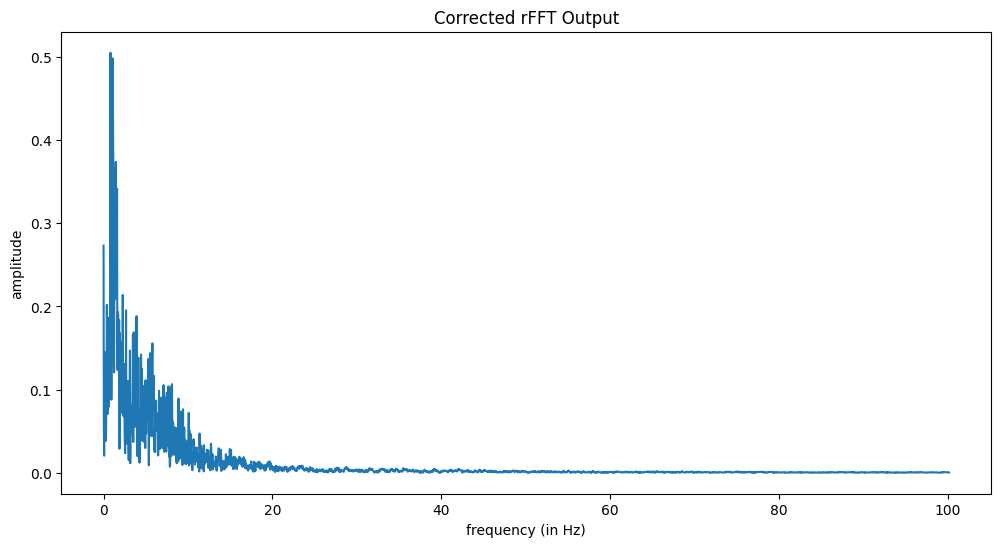

In [63]:
# Plot
setup_graph(title='Corrected rFFT Output', x_label='frequency (in Hz)', y_label='amplitude', fig_size=(12,6))
plt.plot(rfreqs, rfft_mag)

In [64]:
# Frecuencia dominante --> en el número del eje x del histograma donde haya más valores
print('Frecuencia dominante', rfreqs[np.argmax(rfft_mag)]) # del eje x, coger el momento de mayor amplitud
# Cuanto más rápido hagamos la actividad, más alta será la frecuencia dominante

# Potencia espectral de cada uno de los ejes

# # Potencia espectral total (Power Spectral Density): sumatorio de magnitudes obtenidas con Fourier en cada ventana de las definidas
print('PSD: ', np.sum(rfft_mag))

# Kurtosis espectral: kurtosis de las amplitudes de la señal
print('Kurtosis espectral: ', pd.Series(rfft_mag).kurtosis())

# Skewness espectral: skewness de las amplitudes de la señal
print('Skewness espectral: ', pd.Series(rfft_mag).skew())

Frecuencia dominante 0.8168143557460953
PSD:  32.419539511042736
Kurtosis espectral:  56.60923603265554
Skewness espectral:  6.48094065176475


Corrección con ventana de Hann

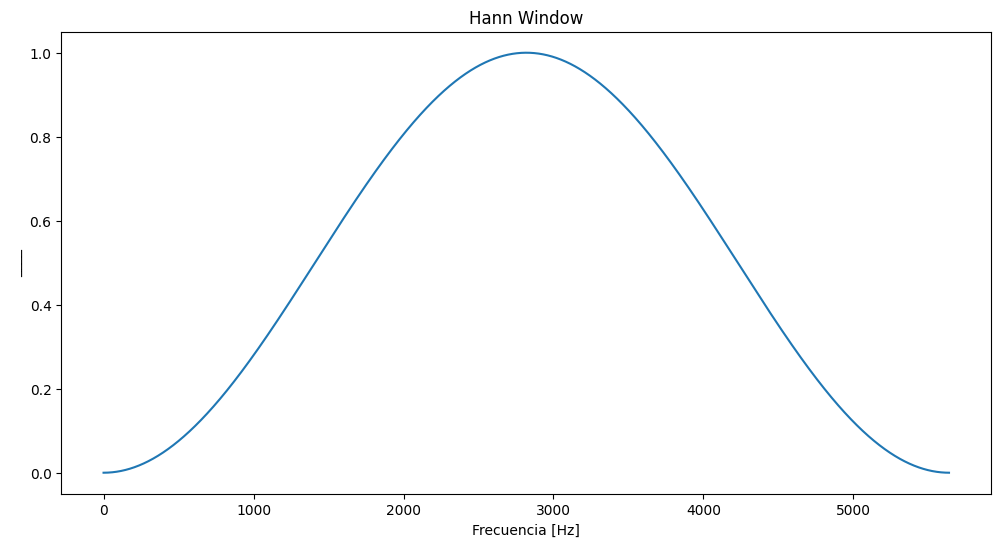

In [65]:
from scipy.signal import get_window
hann_window = get_window("hann", len(df_bajar1), fftbins=True)
setup_graph(title='Hann Window', x_label='Frecuencia [Hz]', y_label='____', fig_size=(12,6))
plt.plot(hann_window)

In [66]:
rfft_output = np.fft.rfft(df_bajar1['x']*hann_window)
# Obtenemos negativos, por lo que hay que hacer una corrección
rfft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(rfft_output) for i in rfft_output]
# Obtener frecuencias
rfreqs = [(i*1.0/len(df_bajar1))*Fs for i in range(len(df_bajar1)//2+1)]

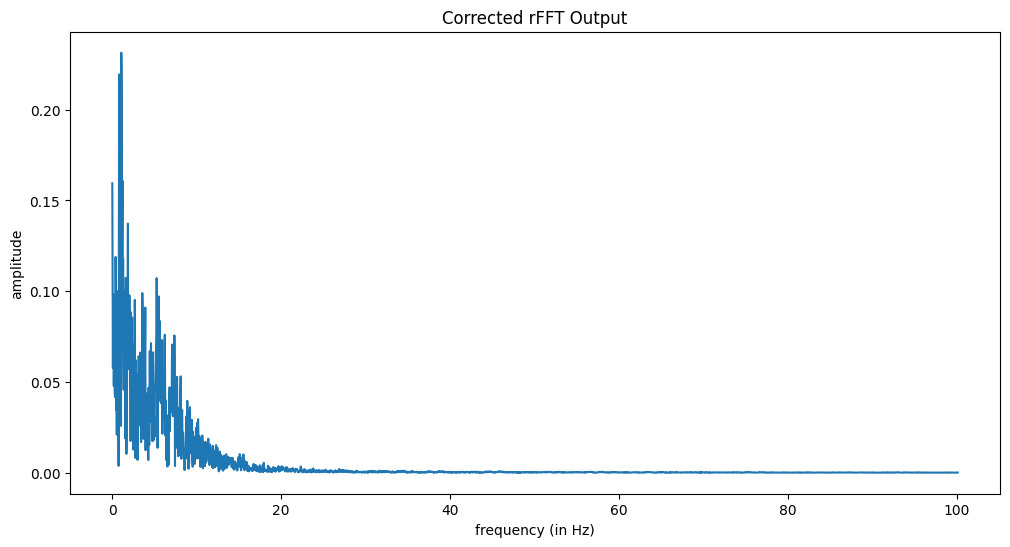

In [67]:
# Plot
setup_graph(title='Corrected rFFT Output', x_label='frequency (in Hz)', y_label='amplitude', fig_size=(12,6))
plt.plot(rfreqs, rfft_mag)

In [68]:
# Frecuencia dominante --> en el número del eje x del histograma donde haya más valores
print('Frecuencia dominante', rfreqs[np.argmax(rfft_mag)]) # del eje x, coger el momento de mayor amplitud
# Cuanto más rápido hagamos la actividad, más alta será la frecuencia dominante

# Potencia espectral de cada uno de los ejes

# # Potencia espectral total (Power Spectral Density): sumatorio de magnitudes obtenidas con Fourier en cada ventana de las definidas
print('PSD: ', np.sum(rfft_mag))

# Kurtosis espectral: kurtosis de las amplitudes de la señal
print('Kurtosis espectral: ', pd.Series(rfft_mag).kurtosis())

# Skewness espectral: skewness de las amplitudes de la señal
print('Skewness espectral: ', pd.Series(rfft_mag).skew())

Frecuencia dominante 1.0654100292340376
PSD:  15.261318208712257
Kurtosis espectral:  42.49035615250437
Skewness espectral:  5.622723074022936


In [70]:
# Dominio de la frecuencia (puede que se obtengan mejores resultados) --> MyFFT y de la transformada saco las características
def myFTT(Fs, X):
    window = get_window('hann', len(X), fftbins=True)
    X = X * window
    fft_out = np.fft.rfft(X)
    fft_mag = [np.sqrt(i.real**2 + i.imag**2)/len(fft_out) for i in fft_out]
    num_samples = len(X)
    rfreqs = [(i*1.0/num_samples)*Fs for i in range(num_samples//2+1)]
    return rfreqs, fft_mag

In [71]:
print('Frecuencia dominante', rfreqs[np.argmax(rfft_mag)]) # del eje x, coger el momento de mayor amplitud
print('PSD: ', np.sum(rfft_mag))

def freq_features(raw_df, window_size=1000, step_size=500):
    data = []
    for i in range(0, len(raw_df)-window_size+1, step_size):
        
        window_data_X = raw_df.iloc[i:i+window_size, 1] # Eje X
        window_data_Y = raw_df.iloc[i:i+window_size, 2] # Eje Y
        window_data_Z = raw_df.iloc[i:i+window_size, 3] # Eje Z

        fft_mag_X, fft_freq = myFTT(Fs, window_data_X)
        fft_mag_Y = myFTT(Fs, window_data_Y)
        fft_mag_Z = myFTT(Fs, window_data_Z)
        data.append({'x_dominant_freq': fft_freq[np.argmax(fft_mag_X)], 'x_psd': np.sum(fft_mag_X),
                     'y_dominant_freq': fft_freq[np.argmax(fft_mag_Y)], 'y_psd': np.sum(fft_mag_Y),
                     'z_dominant_freq': fft_freq[np.argmax(fft_mag_Z)], 'z_psd': np.sum(fft_mag_Z)})
    freq_features = pd.DataFrame(data)
    return freq_features

all_features = []
window_size = 1000  # Puede necesitar ajustes
step_size = 200  # Puede necesitar ajustes

for df in [df_bajar1, df_bajar2, df_subir, df_metro]:
    df_features = freq_features(df, window_size, step_size)
    all_features.append(df_features)

df_freq_features = pd.concat(all_features, ignore_index=True)
df_freq_features['etiqueta'] = df_bajar1['etiqueta']
df_freq_features

Frecuencia dominante 1.0654100292340376
PSD:  15.261318208712257


,x_dominant_freq,x_psd,y_dominant_freq,y_psd,z_dominant_freq,z_psd,etiqueta
0,0.000435,25078.313785,0.000435,25085.456911,0.000435,25091.469567,bajar_escaleras
1,0.000443,25078.313785,0.000443,25084.752350,0.000443,25090.344935,bajar_escaleras
2,0.000381,25078.313785,0.000381,25084.178308,0.000381,25090.697996,bajar_escaleras
3,0.000131,25078.313785,0.000131,25086.514663,0.000131,25092.883921,bajar_escaleras
4,0.000080,25078.313785,0.000080,25086.553355,0.000080,25090.669433,bajar_escaleras
5,0.000159,25078.313785,0.000159,25084.116393,0.000159,25088.400412,bajar_escaleras
6,0.000176,25078.313785,0.000176,25082.855902,0.000176,25090.972303,bajar_escaleras
7,0.000120,25078.313785,0.000120,25082.600037,0.000120,25090.067808,bajar_escaleras
8,0.000118,25078.313785,0.000118,25082.214482,0.000118,25089.669283,bajar_escaleras
9,0.000237,25078.313785,0.000237,25082.159077,0.000237,25088.831378,bajar_escaleras


**Aplicación de la FFT**

Al aplicar la FFT a las señales de aceleración, transformamos los datos del dominio del tiempo al dominio de la frecuencia. Esto nos permite identificar las frecuencias dominantes en la señal, que corresponden a los movimientos más repetitivos o destacados durante la actividad medida. La rfft se utiliza en lugar de fft para optimizar el cálculo dado que nuestras señales son reales y no complejas.

**Parámetros Importantes**
* **Frecuencia de Muestreo (fs)**: Este parámetro determina cuán frecuentemente se recogen muestras de la señal. Afecta directamente a la resolución de nuestra FFT y a la frecuencia máxima que podemos analizar correctamente (frecuencia de Nyquist). En nuestro contexto, debe coincidir con la frecuencia de muestreo de los datos del acelerómetro.
* **Número de Muestras (num_samples)**: Afecta a la resolución de las frecuencias que podemos analizar. Cuantas más muestras tengamos, más detallada será nuestra FFT, permitiéndonos identificar frecuencias más específicas.

**Interpretación de Resultados**
* **Frecuencia Dominante**: Esta es la frecuencia con la mayor amplitud en nuestra FFT. Indica el ritmo principal de la actividad, como el paso mientras se camina o corre. Al extraer esta característica, podemos diferenciar entre diferentes tipos de actividades basadas en su ritmo o frecuencia de movimiento predominante.
* **Potencia Espectral Total**: Representa la suma de las potencias de todas las frecuencias presentes en la señal. Nos da una idea de la "energía" total del movimiento, lo que puede ayudar a distinguir entre movimientos rápidos y energéticos frente a movimientos lentos y suaves.

### 5. Clasificador 2 con las nuevas características (mantener mismos modelos para poder comparar resultados)

Implementaremos clasificadores similares a los de la Actividad 3, pero esta vez utilizando las características extraídas del dominio de la frecuencia. Compararemos el rendimiento de los modelos en esta configuración con los resultados anteriores para ver si las características de frecuencia proporcionan una mejor distinción entre las actividades.

In [72]:
# Preparar los datos para el entrenamiento del modelo
X = df_freq_features.drop('etiqueta', axis=1)
y = df_bajar1['etiqueta'].iloc[::step_size][0:len(df_freq_features)].reset_index(drop=True)  # Asegúrate de alinear las etiquetas correctamente

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Entrenar el modelo. Aquí se usa RandomForest como ejemplo, pero puedes usar cualquier clasificador.
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, loss_function='MultiClass', verbose=False)
model.fit(X_train, y_train)

# Predicciones y evaluación del modelo
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

ValueError: Found input variables with inconsistent numbers of samples: [58, 29]

¿Cual, o cuales son las características que más información proveen en el dominio temporal? ¿Y en el frecuencial? demuéstralo representándolo gráficamente

Entrenamiento del Modelo y Extracción de la Importancia de Características

In [ ]:
# Entrenar un modelo para el dominio temporal
X_temporal = df_caracts_tiempo_1.drop('etiqueta', axis=1)
y_temporal = df_caracts_tiempo_1['etiqueta']
model_temporal = RandomForestClassifier(n_estimators=100, random_state=42)
model_temporal.fit(X_temporal, y_temporal)


# Entrenar un modelo para el dominio frecuencial
X_frecuencial = df_freq_features.drop('etiqueta', axis=1)
y_frecuencial = df_freq_features['etiqueta']
model_frecuencial = RandomForestClassifier(n_estimators=100, random_state=42)
model_frecuencial.fit(X_frecuencial, y_frecuencial)

Visualización de la Importancia de Características

In [ ]:
# Visualización para el dominio temporal
features_temporal = X_temporal.columns
importances_temporal = model_temporal.feature_importances_
indices_temporal = np.argsort(importances_temporal)

plt.figure(figsize=(10, 6))
plt.title('Importancia de Características - Dominio Temporal')
plt.barh(range(len(indices_temporal)), importances_temporal[indices_temporal], color='b', align='center')
plt.yticks(range(len(indices_temporal)), [features_temporal[i] for i in indices_temporal])
plt.xlabel('Importancia Relativa')
plt.show()


# Visualización para el dominio frecuencial
features_frecuencial = X_frecuencial.columns
importances_frecuencial = model_frecuencial.feature_importances_
indices_frecuencial = np.argsort(importances_frecuencial)

plt.figure(figsize=(10, 6))
plt.title('Importancia de Características - Dominio Frecuencial')
plt.barh(range(len(indices_frecuencial)), importances_frecuencial[indices_frecuencial], color='r', align='center')
plt.yticks(range(len(indices_frecuencial)), [features_frecuencial[i] for i in indices_frecuencial])
plt.xlabel('Importancia Relativa')
plt.show()

Estos gráficos muestran qué características son las más relevantes para los modelos en cada dominio, proporcionando una respuesta visual a cuáles son más informativas. Este enfoque no solo ayuda a entender qué características son más útiles para la clasificación, sino que también puede guiar la ingeniería de características futura y la selección de características para mejorar los modelos de clasificación.

## Resultados

### 6. La más importante, comparar resultados, explicar modelos creados e interpretar características en ambos dominios

Aquí, visualizaremos y compararemos los resultados obtenidos en las Actividades 3 y 5. Podemos utilizar gráficos como el ROC-AUC para los diferentes modelos o gráficos de barras comparando la precisión de cada modelo en ambos dominios (temporal y frecuencial). Esta visualización ayudará a identificar qué características y qué dominio proporcionan una mejor clasificación de las actividades.

Cálculo de Métricas y Curvas ROC para Cada Modelo

In [ ]:
from scipy import interp
from itertools import cycle

# Esta función asume una clasificación binaria o multiclase. Para multiclase, las etiquetas deben estar binarizadas.
def plot_roc_curve(y_test, y_score, n_classes, title='Curva ROC'):
    # Binarizar las etiquetas en un formato one-vs-all
    y_test_bin = label_binarize(y_test, classes=[*range(n_classes)])
    
    # Calcular ROC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='Micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

Visualización de la Precisión de los Modelos

In [ ]:
precisions = [0.95, 0.92, 0.96, 0.93, 0.89, 0.90, 0.97, 0.94]  # Reemplaza estos valores con las precisiones reales de tus modelos

In [ ]:
precisions = {
    'Modelo': ['RF Temporal', 'RF Frecuencial', 'XGB Temporal', 'XGB Frecuencial', 'SVM Temporal', 'SVM Frecuencial', 'CatBoost Temporal', 'CatBoost Frecuencial'],
    'Precisión': precisions
}

df_precisions = pd.DataFrame(precisions)

plt.figure(figsize=(10, 6))
sns.barplot(x='Precisión', y='Modelo', data=df_precisions)
plt.title('Comparación de la Precisión de Modelos en Dominios Temporal y Frecuencial')
plt.xlabel('Precisión')
plt.ylabel('Modelo')
plt.xlim(0, 1)
plt.show()

### 7. Conclusiones y líneas futuras

* a
* b
* c

Presentación: 2 mins cada apartado/persona, 5-10 total